In [1]:
import requests
from IPython.display import Markdown

url = 'https://kata.geosci.ai/challenge/prospecting'
r = requests.get(url)
print(r.status_code)
Markdown(r.text)

200


# Prospecting

We have 5 arrays of 4096 elements each. Each array represents a map as a 'raster' with 64 &times; 64 = 4096 pixels, and is given as a row in the dataset. Each pixel is represented by a single integer, taking values from 0 to 8.

The maps represent different things. In order, they are:

1. Reliability of well data.
2. Reliability of seismic data.
3. Porosity from wells and conceptual models.
4. Fracture density from wells and seismic.
5. Our land position (1 denotes 'our land').

We need to answer the following questions:

1. How many pixels have zero total reliability?
2. How many pixels are predicted to have better than 50th percentile (P50) porosity and better than P50 fracture density?
3. How many of these pixels have non-zero reliability and are on our land? These blobs are our _prospects_.
4. Find the product of the (x, y) coordinates of the cell containing the centre of mass of the largest _prospect_ blob.

For question 4, a centre of mass at (3.4, 12.6) is in the cell (3, 12) and you would respond with 3 &times; 12 = **36**.

We'll consider blobs to be connected if they have directly neighbouring pixels. In example A, below, there are 3 'blobs' of one pixel each. In example B there are 2 blobs, each with three pixels.

      A        B
    1 0 1    1 1 0
    0 1 0    1 0 1
    0 0 0    0 1 1


## Example

Here is a dataset of smaller maps. Every row represents a map, each 3 &times 3 pixels:

    example = """0,1,0,1,2,1,0,1,0
                 2,1,0,1,1,1,0,1,0
                 0,1,2,1,3,1,1,2,2
                 0,2,1,2,3,1,1,3,2
                 1,1,1,1,1,1,0,0,0"""

If we re-shaped each row to make a 3 &times; 3 map, the maps would look like:

      1       2       3       4       5    <--- map number
    0 1 0   2 1 0   0 1 2   0 2 1   1 1 1
    1 2 1   1 1 1   1 3 1   2 3 1   1 1 1
    0 1 0   0 1 0   1 2 2   1 3 2   0 0 0   

Here's how we might answer the questions:

1. There are **3** pixels with zeros in both of the reliability maps (the first two maps).
1. The P50 values on maps 3 and 4 are 1 and 2 respectively. There are **2** pixels that are higher on both maps.
1. Of those pixels, **1** has non-zero reliability and is on our land (map 5).
1. The coordinates of that pixels are (1, 1) so the product of those coordinates is **1**.


## Hints

It's likely that the `scipy.ndimage.measurements` module will be useful in answering question 4. For example, if you have an array `arr` like:

    0 1 1
    0 0 0
    1 0 0

Then `scipy.ndimage.measurements.label()` will return two things: the labels and the number 2 (meaning it found 2 objects). The labels have the same shape as the original 'map':

    0 1 1   <--- 1 denotes 'object 1'
    0 0 0   <--- 0 denotes 'background', i.e. no objects
    2 0 0   <--- 2 denotes 'object 2'

Once you have labels, you can get the centre of mass of the object labelled `3` with `scipy.ndimage.measurements.center_of_mass(arr, labels, 3)`.

We will use the default behaviour of the `scipy.ndimage.measurements.label()` function to decide if things are separate objects.


## A quick reminder how this works

You can retrieve your data by choosing any Python string as a **`<KEY>`** and substituting here:
    
    https://kata.geosci.ai/challenge/prospecting?key=<KEY>
                                                     ^^^^^
                                                     use your own string here

To answer question 1, make a request like:

    https://kata.geosci.ai/challenge/prospecting?key=<KEY>&question=1&answer=1234
                                                     ^^^^^          ^        ^^^^
                                                     your key       Q        your answer

[Complete instructions at kata.geosci.ai](https://kata.geosci.ai/challenge)

----

© 2020 Agile Scientific, licensed CC-BY

In [2]:
my_key = "MH - :)"
params = {'key': my_key}
r = requests.get(url, params)
print(r)
source = r.text

<Response [200]>


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label, center_of_mass


def preprocess_arrays(source):
    """Return an array of shape (5, 64, 64) from the data provided by the challenge """
    arrays = [(s.split(',')) for s in source.split('\n')]
    a = np.array(arrays).astype(int)
    a = a.reshape((5, 64, 64))
    return a


def plot_initial_maps(a):
    fig, ax = plt.subplots(ncols=5, figsize=(24, 6), sharey=True)
    titles = ['Well Reliability', 'Seismic Reliability', 'Porosity', 'Fracture Density', 'Land']
    for i in range(5):
        ax[i].imshow(a[i])
        ax[i].set_title(titles[i])
        
    return fig

def generate_decision_maps(a):
    """Return an array of shape (4, 64, 64) containing the decision maps from the source array
    
    Input array shape: (5, 64, 64)
    ------------
    a[0]: Reliability of well data.
    a[1]: Reliability of seismic data.
    a[2]: Porosity from wells and conceptual models.
    a[3]: Fracture density from wells and seismic.
    a[4]: Our land position (1 denotes 'our land') 
    
    Returns: array of shape (4, 64, 64)
    -----------
    a[0]: non zero reliability combines well and seismic
    a[1]: >P50 porosity
    a[2]: >P50 fracture density
    a[3]: land ownership, identical to input[4]
    """
    
    decision_array = np.empty((4, 64, 64))
    
    # non zero reliability
    decision_array[0] = np.any(a[0:2], axis=0)
    
    # P50 porosity
    decision_array[1] = a[2] > np.percentile(a[2], 50)
    
    #p50 fracture density
    decision_array[2] = a[3] > np.percentile(a[3], 50)
    
    # land ownership
    decision_array[3] = a[4].astype('bool')
    
    return decision_array


def owned_prospects(decision_maps):
    """Combine decision maps to find where all conditions are True"""
    return np.all(decision_maps, axis=0)


def plot_decision_maps(decision_maps):
    
    fig, ax = plt.subplots(ncols=4, figsize=(24, 6), sharey=True)
    titles = ['Data Reliability', '>P50 Porosity', '>P50 Fracture Density', 'Land Ownership']
    for i in range(3):
        ax[i].imshow(decision_maps[i])
        ax[i].set_title(titles[i])
    
    # combine the first three decision maps into a geologic prospect map
    ax[3].imshow(np.all(decision_maps[0:3], axis=0))
    ax[3].set_title('Geologic Prospects')
    

def plot_prospects_vs_land(decision_maps):
    fig, ax = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)
    titles = ['Geologic Prospects', 'Land Ownership', 'Owned Prospects']
   
    # combine the first three decision maps into a prospect map
    prospects = np.all(decision_maps[0:3], axis=0)
    ax[0].imshow(prospects)
    ax[0].set_title('Geologic Prospects')
    
    # land map
    ax[1].imshow(decision_maps[3])
    ax[1].set_title('Land Ownership')
    
    # combine land and prospects
    owned_prospects = np.all([prospects, decision_maps[3]], axis=0)
    ax[2].imshow(owned_prospects)
    ax[2].set_title('Owned Prospects')
    
    
def identify_prospect_blobs(prospect_map):
    """Returns an array where each blob has a unique integer value
    and the cell of the array that represents the center of the largest blob"""
    
    # find and label the objects
    objects, _ = label(prospect_map)
    
    # count the number of cells within each object
    unique, counts = np.unique(objects[objects != 0], return_counts=True)
    
    # find center of largest blob
    center_of_largest_blob = center_of_mass(prospect_map, objects, unique[counts.argmax()])
    
    cell_containing_the_center = int(center_of_largest_blob[0]), int(center_of_largest_blob[1])
    
    return objects, cell_containing_the_center
    

def plot_blobs(blobs, center_of_largest_blob):
    fig, ax = plt.subplots()
    ax.imshow(blobs)
    ax.plot(center_of_largest_blob[1], center_of_largest_blob[0], marker='X', c='k', markersize=16)
    ax.set_title('X Marks the Spot')
    
    return fig


## Visualize input data

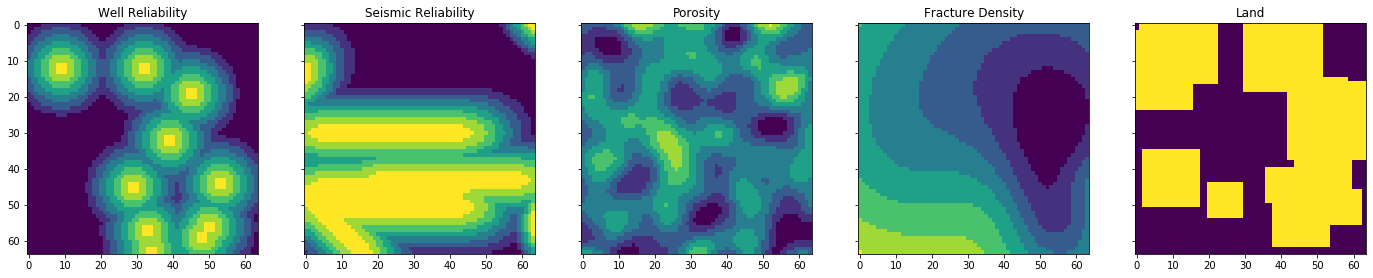

In [27]:
a = preprocess_arrays(source)
fig = plot_initial_maps(a)
fig.savefig('../img/property_maps.png', dpi=600)

## Generate decision maps and geologic prospects

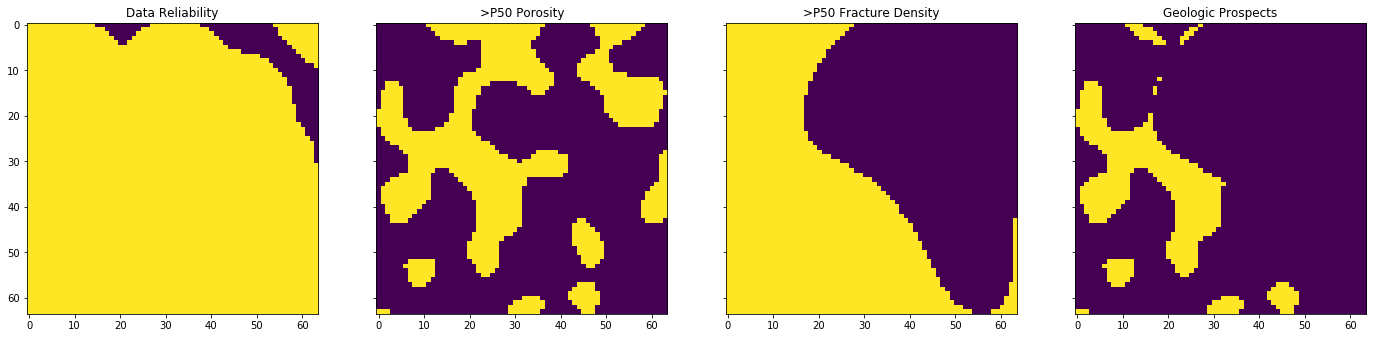

In [5]:
decision_maps = generate_decision_maps(a)
plot_decision_maps(decision_maps)

## Filter the prospects by owned acreage

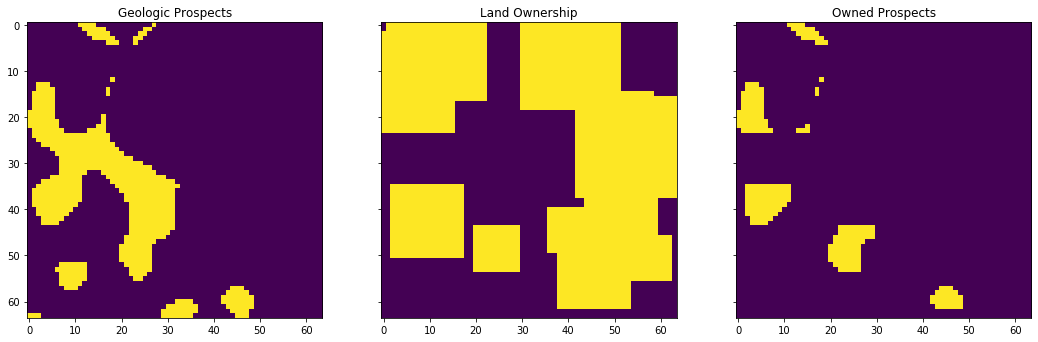

In [6]:
plot_prospects_vs_land(decision_maps)
final_prospect_map = owned_prospects(decision_maps)

# Identify individual prospect blobs

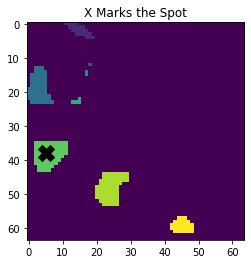

In [23]:
blobs, center_of_largest = identify_prospect_blobs(final_prospect_map)
fig = plot_blobs(blobs, center_of_largest)
fig.savefig('../img/prospect_blobs.png')

## Submit Answers

In [ ]:
answer1 = np.sum(~decision_maps[0].astype(bool))
answer2 = np.sum(np.all(decision_maps[1:3], axis=0))
answer3 = np.sum(np.all(decision_maps, axis=0))
answer4 = center_of_largest[0] * center_of_largest[1]

print(answer1, answer2, answer3, answer4)

In [ ]:
params = {'key': my_key,
          'question': 1,
          'answer': answer1
         }

r = requests.get(url, params)
print(r)
print(r.text)

In [ ]:
params = {'key': my_key,
          'question': 2,
          'answer': answer2
         }

r = requests.get(url, params)
print(r)
print(r.text)

In [ ]:
params = {'key': my_key,
          'question': 3,
          'answer': answer3
         }

r = requests.get(url, params)
print(r)
print(r.text)

In [ ]:
params = {'key': my_key,
          'question': 4,
          'answer': answer4
         }

r = requests.get(url, params)
print(r)
print(r.text)